In [1]:
import numpy as np 
import os 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import tensorflow as tf

In [2]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
print(x_train.shape)

# train set / data 
x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [84,84]).numpy()
x_test = np.expand_dims(x_train, axis=-1)
x_test = tf.image.resize(x_train, [84,84]).numpy()
y_train = y_train.astype('int') 
y_test = y_test.astype('int') 

print(x_train.shape) 

(60000, 28, 28)
(60000, 84, 84, 1)


In [4]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)] 
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups]) 
print('test groups:', [x.shape[0] for x in test_groups]) 

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [5]:
def gen_random_batch(in_groups, batch_halfsize = 8):
  out_img_a, out_img_b, out_score = [], [], []
  all_groups = list(range(len(in_groups)))
  for match_group in [True, False]:
    group_idx = np.random.choice(all_groups, size = batch_halfsize)
    out_img_a += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
    if match_group:
      b_group_idx = group_idx
      out_score += [1]*batch_halfsize
    else:
      # anything but the same group
      non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
      b_group_idx = non_group_idx
      out_score += [0]*batch_halfsize
    out_img_b += [in_groups[c_idx]
[np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
  return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

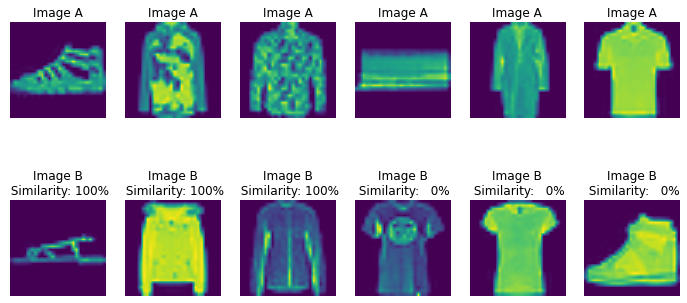

In [6]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations

In [8]:

def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
  x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
  x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
  if act:
    x = Activation('relu',name=name+'conv2d'+'act')(x)
  return x

In [9]:
def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

In [10]:
def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

In [11]:
def incresC(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

In [12]:
img_input = Input(shape=(84,84,1))

x = conv2d(img_input,32,3,2,'valid',True,name='conv1')
x = conv2d(x,32,3,1,'valid',True,name='conv2')
x = conv2d(x,64,3,1,'valid',True,name='conv3')

x_11 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,64,3,1,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

In [13]:
#Inception-ResNet-A modules
x = incresA(x,0.15,name='incresA_1')
x = incresA(x,0.15,name='incresA_2')
x = incresA(x,0.15,name='incresA_3')
x = incresA(x,0.15,name='incresA_4')


#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

#Inception-ResNet-B modules
x = incresB(x,0.1,name='incresB_1')
x = incresB(x,0.1,name='incresB_2')
x = incresB(x,0.1,name='incresB_3')
x = incresB(x,0.1,name='incresB_4')
x = incresB(x,0.1,name='incresB_5')
x = incresB(x,0.1,name='incresB_6')
x = incresB(x,0.1,name='incresB_7')


#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

#Inception-ResNet-C modules
x = incresC(x,0.2,name='incresC_1')
x = incresC(x,0.2,name='incresC_2')
x = incresC(x,0.2,name='incresC_3')

#TOP
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(36, activation='relu')(x)

In [14]:
model = Model(img_input,x,name= 'inception_resnet_v2')
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 conv1conv2d (Conv2D)           (None, 41, 41, 32)   288         ['input_1[0][0]']                
                                                                                                  
 conv1conv2dbn (BatchNormalizat  (None, 41, 41, 32)  96          ['conv1conv2d[0][0]']            
 ion)                                                                                             
                                                                                                  
 conv1conv2dact (Activation)    (None, 41, 41, 32)   0           ['conv1conv2dbn

In [15]:
# model.compile(Adam(lr=0.0001), 
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [16]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 84, 84, 1)]  0           []                               
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 36)          23986628    ['ImageA_Input[0][0]',           
 l)                                                               'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 72)           0           ['inception_resnet

In [17]:
# setup the optimization process
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
similarity_model.compile(optimizer=opt, loss = 'binary_crossentropy',
metrics = ['mae'])

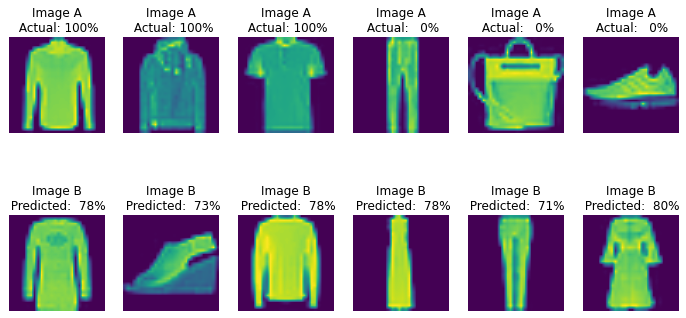

In [18]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig
  
# a completely untrained model
_ = show_model_output()

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.0001, verbose=1)

In [20]:
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)


loss_history = similarity_model.fit(siam_gen(train_groups), 
                                    steps_per_epoch = 500,
                                    validation_data=([valid_a, valid_b],
                                                     valid_sim), 
                                    callbacks=[early_stopping, reduce_lr],
                                    epochs=5,
                                    verbose=True)

Epoch 1/5
500/500 [==============================] - 948s 2s/step - loss: 0.5078 - mae: 0.3477 - val_loss: 0.9818 - val_mae: 0.5002 - lr: 0.0100
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 0.4532 - mae: 0.3025
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
500/500 [==============================] - 911s 2s/step - loss: 0.4532 - mae: 0.3025 - val_loss: 2.0306 - val_mae: 0.5126 - lr: 0.0100
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 0.3972 - mae: 0.2613
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
500/500 [==============================] - 913s 2s/step - loss: 0.3972 - mae: 0.2613 - val_loss: 2.2604 - val_mae: 0.5150 - lr: 0.0020
Epoch 4/5
500/500 [==============================] - ETA: 0s - loss: 0.3808 - mae: 0.2497
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001.
500/500 [==============================] - 916s 2s/step - loss: 0.3808 - mae: 0.2497 - val_loss: 1.970

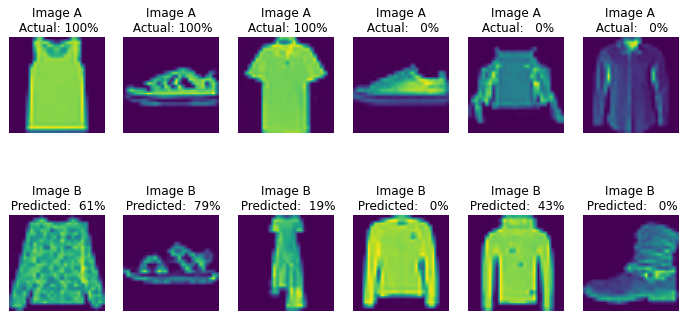

In [21]:
_ = show_model_output()

In [ ]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose =
True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose
= True, batch_size = 128)

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                  ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
              ankle_boot_score[np.where(y_test == c_group), 0],
              marker='.',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [ ]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=1000,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

In [ ]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
                  'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                  ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(tsne_features[np.where(y_test == c_group), 0],
              tsne_features[np.where(y_test == c_group), 1],
              marker='o',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)